In [41]:
import pandas as pd
from textblob import TextBlob as tb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from wordcloud import WordCloud
import pyLDAvis, pyLDAvis.sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation, PCA
pyLDAvis.enable_notebook()
style.use('fivethirtyeight')

In [42]:
df = pd.read_csv('preprocessed_data_2.csv')
df.rename({'Unnamed: 0' : 'index'}, axis=1, inplace=True)
df = df.set_index('index')
df.head()

,id,depth,parent_id,score,lemmatized,lemm_sub,sentiment,subjectivity,sentiment_sub,subjectivity_sub,labels
index,,,,,,,,,,,
0,d4xury6,0,t3_4r2tl4,31,no question want thank post topic birth contro...,updated september scroll downhi lengthy post c...,0.333333,0.416667,0.109876,0.533718,supporting
1,d4yi9y9,0,t3_4r2tl4,7,holy shit thank much someone recently turn sup...,updated september scroll downhi lengthy post c...,0.104167,0.308333,0.109876,0.533718,supporting
2,d4yhm4h,0,t3_4r2tl4,7,people nice friendly super non judgmental espe...,updated september scroll downhi lengthy post c...,0.189815,0.540741,0.109876,0.533718,commenting
3,d4y5kmd,0,t3_4r2tl4,3,thanks post tried yaz oral contraceptive prior...,updated september scroll downhi lengthy post c...,0.133333,0.133333,0.109876,0.533718,supporting
4,d4y8tvk,0,t3_4r2tl4,3,minor need show parent consent,updated september scroll downhi lengthy post c...,-0.050000,0.200000,0.109876,0.533718,questioning


### Text Representation

In [43]:
def texts_to_ngram(texts, n=2):
    texts = texts['lemm_sub']
    vectorizer = CountVectorizer(
        ngram_range=(n, n),
        token_pattern=r'\b\w+\b',
        min_df=1,
        max_features=2000)
    dtm = vectorizer.fit_transform(texts)
    #pickle.dump(vectorizer, open('out/ngram.pk', 'wb'))
    return dtm, vectorizer

def texts_to_tfidf(texts):
    texts = texts['lemm_sub']
    vectorizer = TfidfVectorizer(max_features=2000)
    tfidf = vectorizer.fit_transform(texts)
    #pickle.dump(vectorizer, open('out/tfidf.pk', 'wb'))
    return tfidf, vectorizer

In [44]:
# Get ngram matrix
ngram, ngram_v = texts_to_ngram(df, n=2)
print('Ngram matrix shape:', ngram.toarray().shape)
list(ngram_v.vocabulary_.items())[0:5]

Ngram matrix shape: (1155, 2000)


[('updated september', 1872),
 ('september scroll', 1598),
 ('scroll downhi', 1588),
 ('downhi lengthy', 440),
 ('lengthy post', 976)]

In [45]:
# Get TFIDF matrix
tfidf, tfidf_v = texts_to_tfidf(df)
print('TFIDF matrix shape:', tfidf.toarray().shape)
list(tfidf_v.vocabulary_.items())[0:5]

TFIDF matrix shape: (1155, 2000)


[('updated', 1892),
 ('september', 1590),
 ('scroll', 1574),
 ('downhi', 479),
 ('lengthy', 959)]

## Term Frequencies

In [46]:
def vector_to_frequency(vector, vectorizer):
    """
    Return a list of words and their corresponding occurence in the corpus
    """
    total = vector.sum(axis=0)
    frequency = [(w, total[0, i]) for w, i in vectorizer.vocabulary_.items()]
    frequency = pd.DataFrame(frequency, columns=['term', 'frequency'])
    frequency = frequency.sort_values(by='frequency', ascending=False).reset_index(drop=True)
    return frequency

In [47]:
freq_ngram = vector_to_frequency(ngram, ngram_v)
freq_ngram.head()

,term,frequency
0,birth control,616
1,likhaan center,459
2,trust pill,376
3,womens health,370
4,center womens,370


In [48]:
freq_tfidf = vector_to_frequency(tfidf, tfidf_v)
freq_tfidf.head()

,term,frequency
0,get,72.868814
1,pill,66.972053
2,not,61.903805
3,condom,60.499859
4,use,53.442048


## Text Analysis

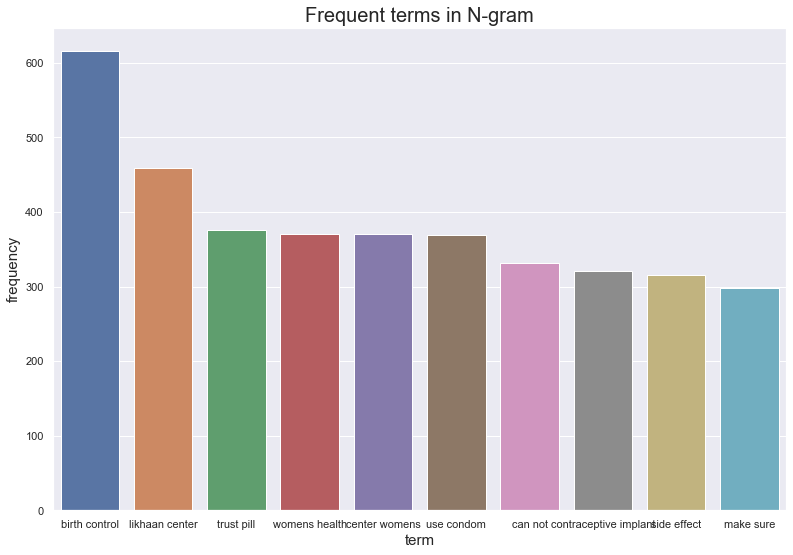

In [62]:
# Visualize frequencies
bar_ngram = sns.barplot(data=freq_ngram.head(10), x='term',
            y='frequency').set_title("Frequent terms in N-gram", fontsize=20)
sns.set(rc={
    'figure.figsize':(11.7,8.27),
    'font.size':15,
    'axes.titlesize':15,
    'axes.labelsize':15,
})

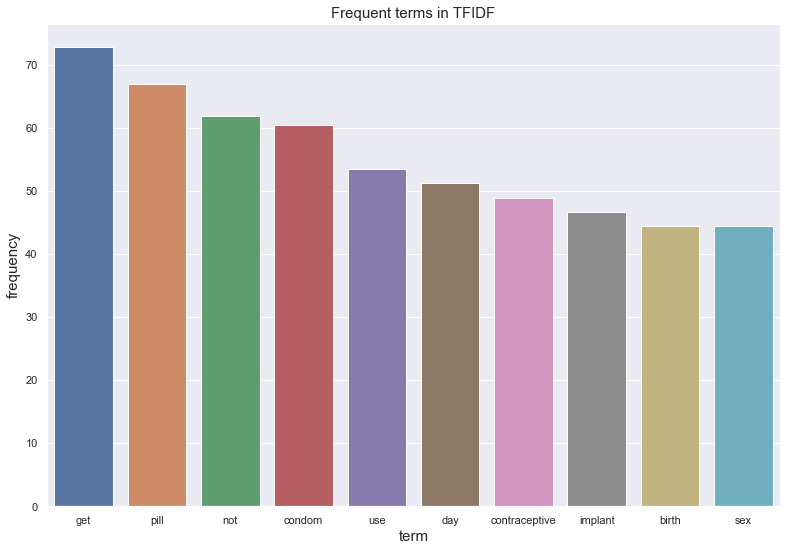

In [50]:
# Visualize frequencies
tfidf_ngram = sns.barplot(data=freq_tfidf.head(10), x='term',
            y='frequency').set_title("Frequent terms in TFIDF", fontsize=15)
sns.set(rc={
    'figure.figsize':(11.7,8.27),
    'font.size':15,
    'axes.titlesize':15,
    'axes.labelsize':15,
})

## Sentiment Analysis

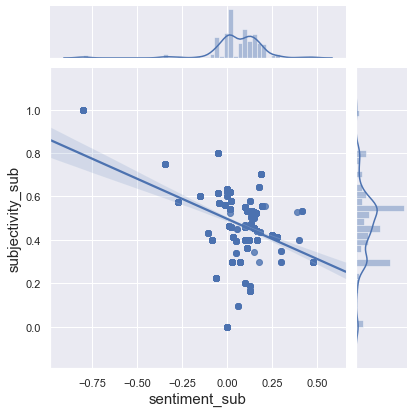

In [66]:
# Visualize distribution of sentiment and subjectivity
sns.jointplot(data=df, x='sentiment_sub', y='subjectivity_sub', kind='reg') 

## WordCloud

In [53]:
def create_wordcloud(texts, max_words=500):
    
    # Transform text for WordCloud
    texts = texts['lemm_sub']
    texts = texts.dropna()
    texts = ' '.join(texts)
    texts = texts.replace(' ', ',')
    
    # Generate wordcloud image
    wc = WordCloud(background_color="white", max_words=max_words, colormap='plasma')
    wc.generate(texts)
    plt.imshow(wc, interpolation='bilinear')
    plt.title('WordCloud of Submissions', size=30)
    plt.axis("off")

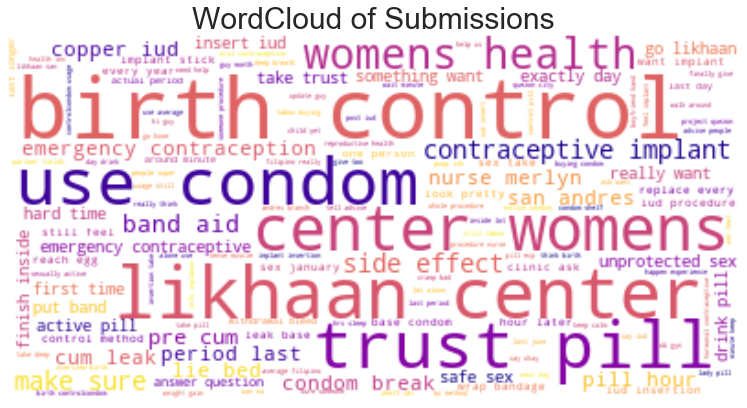

In [54]:
create_wordcloud(df)

## Text Modeling

In [55]:
# Load terms from existing vectorizers
ngram_terms = ngram_v.get_feature_names()
tfidf_terms = tfidf_v.get_feature_names()

### Latent Dirichlet Allocation

In [56]:
def lda(texts):
    """
    Executes LDA algorithm to determine topics of the corpus
    """
    lda_model = LatentDirichletAllocation(
        n_components=5, max_iter=10,
        learning_method='online', 
        learning_offset=50., random_state=0)
    lda_model.fit_transform(texts)
    return lda_model

In [57]:
# Execute LDA
ngram_lda = lda(ngram)
tfidf_lda = lda(tfidf)

In [58]:
ngram_lda = pyLDAvis.sklearn.prepare(ngram_lda, ngram, ngram_v)
pyLDAvis.save_html(ngram_lda, 'lda/ngram_lda_sub.html')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [59]:
tfidf_lda = pyLDAvis.sklearn.prepare(tfidf_lda, tfidf, tfidf_v)
pyLDAvis.save_html(tfidf_lda, 'lda/tfidf_lda_sub.html')

In [60]:
# Code obtained from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(tfidf)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, tfidf_v, number_words)

Topics found via LDA:

Topic #0:
since implant pill not sex get us january sister period

Topic #1:
pill drink day sperm remain life lady hour control get

Topic #2:
fluids base leak morning notice emergency contraceptive condom good sex

Topic #3:
doctor po oh mga kill ako big noong hospital condom

Topic #4:
taboo usage controlcondom shelf average buying get alone still filipino
